# Homework 1 - Python Refresher

## Problem 1: _Only What's Inside Counts_ - Spatial Masking and Local Statistics


Let: `A = torch.randn(120, 80)`

**(a)** Construct a boolean mask tensor `M` (same shape as `A`) that is `True` only inside the rectangular window:
- rows indexed **20–89** (both inclusive)
- columns indexed **10–59** (both inclusive)

Everywhere else, it should be `False`. (**Don't use `for` loops**)

In [1]:
import torch

# Given
A = torch.randn(120, 80)

# -------------------------
# (a) Build mask M (no loops)
# -------------------------
rows = torch.arange(A.shape[0])[:, None]   # (120, 1)
cols = torch.arange(A.shape[1])[None, :]   # (1, 80)

M = (rows >= 20) & (rows <= 89) & (cols >= 10) & (cols <= 59)

print("M shape:", M.shape)
print("M True count:", M.sum().item())

# to verify if our M is correct, we do the following: 
# if M[20:90,10:60] is all True, ~M[20:90,10:60] should be all False
# torch.any() return True even if there is a single True in the tensor
# but since we want to check if all are False, we expect torch.any(~M[20:90,10:60]) to return False
print(torch.any(~M[20:90,10:60])) 


M shape: torch.Size([120, 80])
M True count: 3500
tensor(False)


**(b)** Create a tensor `B` such that:
- inside the window: `B = A`
- outside the window: `B = 0`

In [2]:
# -------------------------
# (b) Masked tensor B
# -------------------------
B = torch.where(M, A, torch.zeros_like(A))
# Equivalent: B = A * M  (since M is bool; PyTorch will cast to 0/1)
# but torch.where is explicit.


**(c)** Compute:
1. mean of entries in `A` **inside** the rectangular window  

2. mean of entries in `A` **outside** the rectangular window  

3. Row-wise means inside the window. Compute a tensor `row_mean_in` of shape `(120,)` such that:
   - `row_mean_in[i]` equals the mean of the entries of **row `i`** of `A` that lie **inside the window only**
   - entries of row `i` that lie **outside the window** must **not** be included in the mean
   - if row `i` has **no entries inside the window**, set `row_mean_in[i] = nan`


In [3]:
# -------------------------
# (c) Masked means
# -------------------------
inside_vals = A[M]
outside_vals = A[~M]

mean_inside = inside_vals.mean()
mean_outside = outside_vals.mean()

# Row-wise mean inside window (return nan if a row has no True entries)
# Count of True per row:
count_in_row = M.sum(dim=1)  # (120,)
sum_in_row = (A * M).sum(dim=1)  # masked sum, (120,)

row_mean_in = sum_in_row / count_in_row
row_mean_in[count_in_row == 0] = float("nan")

print("Mean inside window:", mean_inside.item())
print("Mean outside window:", mean_outside.item())
print(f"row_mean_in:", row_mean_in)
print("row_mean_in shape:", row_mean_in.shape)

Mean inside window: 0.012022297829389572
Mean outside window: 0.002513917163014412
row_mean_in: tensor([        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
         1.9355e-01, -8.5643e-02,  3.5570e-01, -2.2566e-01, -3.4200e-01,
         9.6252e-02,  1.7186e-01,  1.5641e-01, -8.1733e-03,  5.1245e-02,
        -7.4369e-04,  1.2250e-01,  1.9227e-01, -6.0733e-02, -6.6441e-02,
        -9.8042e-02,  1.4888e-01,  1.1969e-01,  1.5910e-02, -1.1688e-01,
        -1.6013e-02,  1.0683e-02,  1.7209e-02,  2.1186e-02,  9.0011e-02,
        -1.3246e-01,  1.9058e-02,  2.3601e-02,  1.2565e-01,  1.5830e-01,
        -2.4685e-02, -6.4434e-02,  4.9055e-02, -3.7621e-01,  6.8674e-02,
        -1.1282e-02,  2.9843e-04, -2.8208e-01, -1.0461e-01,  2.9999e-01,
         7.1485e-02, -2.0706


**(d)** For the tensor `A`, find the location `(i, j)` of the maximum absolute value **within the window only**, and print:
- the index `(i, j)`
- the value `A[i, j]`

*Hint:* `masked_fill`, `argmax`, and unraveling indices will help.

In [4]:
# -------------------------
# (d) Max abs value inside window
# -------------------------
# Fill outside window with -inf so argmax ignores it
absA = A.abs()
masked_absA = absA.masked_fill(~M, float("-inf"))

flat_idx = torch.argmax(masked_absA)  # index into flattened tensor
i = flat_idx // A.shape[1]
j = flat_idx % A.shape[1]

print("Max-abs inside window at (i, j) =", (int(i), int(j)))
print("A[i, j] =", A[i, j].item())
print("|A[i, j]| =", absA[i, j].item())

Max-abs inside window at (i, j) = (27, 18)
A[i, j] = 3.669823408126831
|A[i, j]| = 3.669823408126831


## Problem 2: Broadcast This!

Create a tensor `A` with shape `(5, 10, 15, 20)`:
- `A = torch.randn(5, 10, 15, 20)`

**(a)** Construct a reference tensor `V` of shape `(10,)` equal to `V = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`. 

In [5]:
import torch

# Given
A = torch.randn(5, 10, 15, 20)

# (a) Create V = [0,1,2,...,9]
V = torch.arange(10, dtype=A.dtype, device=A.device)  # shape (10,)


**(b)** Create a tensor `B` with the same shape as `A` (`(5, 10, 15, 20)`) such that for **every** `i, j, k`:
- `B[i, :, j, k]` is exactly the vector `V`

Do not use `for` loops.

In [6]:
# (b) Create B so that B[i, :, j, k] = V for all i,j,k (no loops)
# Reshape V to (1,10,1,1) so it broadcasts over (5,10,15,20)
B = V.view(1, 10, 1, 1).expand_as(A)


**(c)** Create the tensor `C = A + B` using broacasting and print `C.shape`.

In [7]:
# (c) Create C = A + B
C = A + B
print("C.shape =", C.shape)

C.shape = torch.Size([5, 10, 15, 20])


**(d)** Pick **two random** index triples `(i, j, k)` and verify with prints that:
- `B[i, :, j, k]` equals `V`
- `C[i, :, j, k]` equals `A[i, :, j, k] + V`

(You may use `torch.allclose` or print the tensors directly)

In [8]:
# (d) Verification with two random index triples

for _ in range(2):
    i = torch.randint(0, A.shape[0], (1,)).item()
    j = torch.randint(0, A.shape[2], (1,)).item()
    k = torch.randint(0, A.shape[3], (1,)).item()

    print(f"\nChecking indices (i, j, k) = ({i}, {j}, {k})")

    # Check B slice
    print("B[i, :, j, k] equals V:",
          torch.allclose(B[i, :, j, k], V))

    # Check C slice
    print("C[i, :, j, k] equals A[i, :, j, k] + V:",
          torch.allclose(C[i, :, j, k], A[i, :, j, k] + V))

    # Optional: print a few values for clarity
    print("A[i, :, j, k] =", A[i, :, j, k])
    print("B[i, :, j, k] =", B[i, :, j, k])
    print("C[i, :, j, k] =", C[i, :, j, k])
    print("V =", V)


Checking indices (i, j, k) = (1, 10, 16)
B[i, :, j, k] equals V: True
C[i, :, j, k] equals A[i, :, j, k] + V: True
A[i, :, j, k] = tensor([ 0.0853,  0.3347, -1.4051,  0.5312, -1.2766,  0.8695,  0.3071,  0.4844,
        -0.8541,  0.2819])
B[i, :, j, k] = tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
C[i, :, j, k] = tensor([0.0853, 1.3347, 0.5949, 3.5312, 2.7234, 5.8695, 6.3071, 7.4844, 7.1459,
        9.2819])
V = tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

Checking indices (i, j, k) = (2, 3, 15)
B[i, :, j, k] equals V: True
C[i, :, j, k] equals A[i, :, j, k] + V: True
A[i, :, j, k] = tensor([-0.0380, -0.8193,  0.5523, -1.3124,  0.6531,  0.8677, -1.3533, -0.3395,
        -0.6102,  1.1427])
B[i, :, j, k] = tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
C[i, :, j, k] = tensor([-0.0380,  0.1807,  2.5523,  1.6876,  4.6531,  5.8677,  4.6467,  6.6605,
         7.3898, 10.1427])
V = tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


## Problem 3: Everything Is a Vector If You Flatten Hard Enough

Let:
- `A = torch.randn(3, 4, 5)`
- `B = torch.randn(3, 4, 5)`


**(a)** Compute the dot product between `A` and `B` as if they were vectors  
(i.e., flatten both tensors and compute a single scalar dot product).

*Hint:* `torch.dot(A.flatten(), B.flatten())`

In [9]:
import torch

# Given tensors
A = torch.randn(3, 4, 5)
B = torch.randn(3, 4, 5)

# (a) Dot product treating A and B as vectors
dot_full = torch.dot(A.flatten(), B.flatten())
print("Dot product of A and B (flattened):", dot_full.item())

Dot product of A and B (flattened): 5.28656530380249


**(b)** Compute the dot product between the slices `A[2, :, :]` and `A[0, :, :]` by treating each slice as a vector.

In [10]:
dot_slice_rows = torch.dot(A[2, :, :].flatten(), A[0, :, :].flatten())
print("Dot product of A[2,:,:] and A[0,:,:]:", dot_slice_rows.item())

Dot product of A[2,:,:] and A[0,:,:]: 9.226410865783691


**(c)** Compute the dot product between the slices `A[:, 1, :]` and `A[:, 3, :]` by treating each slice as a vector.

In [11]:
dot_slice_cols = torch.dot(A[:, 1, :].flatten(), A[:, 3, :].flatten())
print("Dot product of A[:,1,:] and A[:,3,:]:", dot_slice_cols.item())


Dot product of A[:,1,:] and A[:,3,:]: 0.25769007205963135


## Problem 4: Dot Product Multiverse

**(a)** Let `A = torch.randn(3, 4, 5)`.

We want to compute dot products of the following form:
- pick one row from `A[r, i, :]`
- pick another row from `A[s, k, :]`
- compute the dot product along the last dimension (length 5)

Create an output tensor `D` of shape `(3, 4, 3, 4)` such that:

`D[r, i, s, k]` = $\langle$ `A[r, i, :]`$,$ `A[s, k, :]` $\rangle$

where $\langle \cdot, \cdot \rangle$ denotes the dot product over the last dimension.

**Implementation requirements:** Use broadcasting and/or `torch.einsum`.  



In [12]:
import torch

# Given
A = torch.randn(3, 4, 5)

# Compute D[r, i, s, k] = dot(A[r, i, :], A[s, k, :]) using einsum
# Contract over the last dimension (length 5)
D = torch.einsum("rif,skf->risk", A, A)   # shape (3, 4, 3, 4)
print("D.shape =", D.shape)

D.shape = torch.Size([3, 4, 3, 4])


**(b)** Verify your implementation by checking at least one entry, for example:

`D[1, 2, 0, 3]` $\approx$ $\langle$ `A[1, 2, :]`, `A[0, 3, :]` $\rangle$

(allow a small numerical tolerance, like $10^{-6}$).

In [13]:
# Verification check (allow small tolerance)
lhs = D[1, 2, 0, 3]
rhs = torch.dot(A[1, 2, :], A[0, 3, :])

print("D[1,2,0,3] =", lhs.item())
print("dot(A[1,2,:], A[0,3,:]) =", rhs.item())
print("Allclose? ", torch.allclose(lhs, rhs, atol=1e-6))

D[1,2,0,3] = -0.9549527168273926
dot(A[1,2,:], A[0,3,:]) = -0.9549527168273926
Allclose?  True


**(c)** Symmetry check: Check whether the following symmetry property holds numerically:

`D[r, i, s, k] == D[s, k, r, i]`

Verify this for at least two randomly chosen index quadruple.

In [14]:
r = torch.randint(0, A.shape[0], (1,)).item()   # 0..2
i = torch.randint(0, A.shape[1], (1,)).item()   # 0..3
s = torch.randint(0, A.shape[0], (1,)).item()   # 0..2
k = torch.randint(0, A.shape[1], (1,)).item()   # 0..3

lhs = D[r, i, s, k]
rhs = D[s, k, r, i]

print(f"Random indices (r,i,s,k)=({r},{i},{s},{k})")
print("D[r,i,s,k] =", lhs.item())
print("D[s,k,r,i] =", rhs.item())
print("Symmetry holds (allclose)?", torch.allclose(lhs, rhs, atol=1e-6))

Random indices (r,i,s,k)=(1,1,1,3)
D[r,i,s,k] = 0.031200123950839043
D[s,k,r,i] = 0.031200123950839043
Symmetry holds (allclose)? True


**(d)** Diagonal interpretation: Construct a tensor `E` of shape `(3, 4)` defined by:

`E[r, i] = D[r, i, r, i]`

You nested `for` loops for this task. What does `E[r, i]` represent in terms of `A`?  
(Answer briefly in a comment.)

In [15]:
E = torch.empty((A.shape[0], A.shape[1]), dtype=A.dtype)
for r in range(A.shape[0]):
    for i in range(A.shape[1]):
        E[r, i] = D[r, i, r, i]

print("E.shape =", E.shape)

# Interpretation:
# E[r,i] = dot(A[r,i,:], A[r,i,:]) = ||A[r,i,:]||^2 (squared L2 norm of that 5-vector)
# Verify quickly for one example:
r0, i0 = 1, 2
print("E[1,2] =", E[r0, i0].item())
print("||A[1,2,:]||^2 =", torch.dot(A[r0, i0, :], A[r0, i0, :]).item())

E.shape = torch.Size([3, 4])
E[1,2] = 1.1329028606414795
||A[1,2,:]||^2 = 1.1329028606414795


## Problem 5: _Two Twins Walk Away_ - The Traveling Waves

We will use the closed-form wave equation solution:
- $u(x, t) = \frac{1}{2}[f(x + t) + f(x - t)]$

with initial condition:
- $f(x) = u(x, 0) = \exp(-10 x^2) \sin(x)$

**(a)** Create a tensor `x` on a suitable domain, e.g. `x` $\in$ `[-4, 4]` with 1000 points. Implement `f(x)` as a python function. 

In [16]:
import torch
import matplotlib.pyplot as plt

# (a) Domain
x = torch.linspace(-4.0, 4.0, 1000)

# Initial condition f(x)
def f(x):
    return torch.exp(-10.0 * x**2) * torch.sin(x)

**(b)** Implement a function `u(x, t)` using the formula above. Do **not** use loops over `x` (vectorized operations only).

In [17]:
# (b) Wave solution u(x,t)
def u(x, t):
    t = torch.tensor(t, dtype=x.dtype, device=x.device)  # ensure torch scalar
    return 0.5 * (f(x + t) + f(x - t))

**(c)** Plot `u(x, t)` for `t = 0, 0.25, 0.5, 1.0, 5.0, 10.0` as line plots on the same figure, with legend and axis labels and a figure title. 


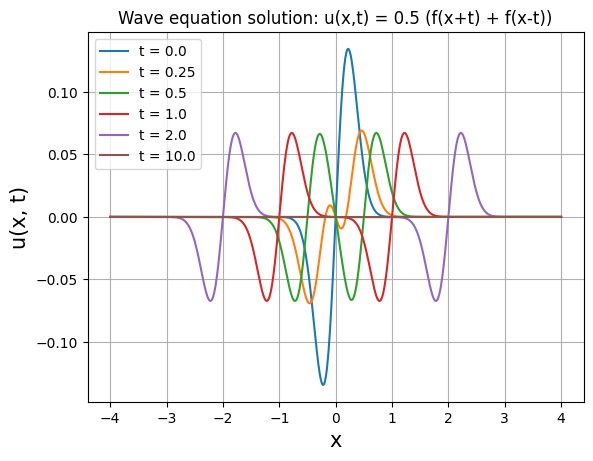

In [18]:
# (c) Plot for multiple times
times = [0.0, 0.25, 0.5, 1.0, 2.0, 10.0]
for t in times:
    plt.plot(x, u(x, t), label=f"t = {t}")
plt.xlabel("x", fontsize=15)
plt.ylabel("u(x, t)", fontsize=15)
plt.title("Wave equation solution: u(x,t) = 0.5 (f(x+t) + f(x-t))")
plt.legend()
plt.grid(True)
plt.show()

**(d)** In 2–3 sentences, describe what happens to the “shape” of the wave as `t` increases (does it shift, split, change amplitude, etc.?)


In [19]:
# (d) Brief explanation:
# As t increases, the initial waveform effectively splits into two copies:
# one traveling to the left f(x+t) and one traveling to the right f(x-t).
# Each copy keeps the same general shape (no diffusion), just shifts position 
# over time.

## Problem 6: Finding Peaks and Pits on a 2D Meshgrid

Define the function:
- $z(x, y) = \exp(-10(x^2 + y^2)) \sin(2\pi x) \sin(2 \pi y)$

**(a)** Create a 2D grid on `x, y ∈ [-1, 1]` with **300 points** in each direction using:
- `torch.linspace`
- `torch.meshgrid(..., indexing="ij")`

In [20]:
import torch
import matplotlib.pyplot as plt
import math

# (a) Create grid
n = 300
x = torch.linspace(-1.0, 1.0, n)
y = torch.linspace(-1.0, 1.0, n)
X, Y = torch.meshgrid(x, y, indexing="ij")  # shapes (n, n)

**(b)** Compute the 2D tensor `Z` on this grid.

In [21]:
# (b) Compute Z using PyTorch only
Z = torch.exp(-10.0 * (X**2 + Y**2)) * torch.sin(2.0 * math.pi * X) * torch.sin(2.0 * math.pi * Y)

**(c)** Find and print:
- `Z.max()` and the index `(i, j)` where it occurs (use `torch.argmax` + unravel)
- `Z.min()` and the index `(i, j)` where it occurs (use `torch.argmin` + unravel)

In [22]:
# -------------------------
# (c) Find max/min values and their (i,j) indices
# -------------------------
flat_max = torch.argmax(Z)
i_max, j_max = torch.unravel_index(flat_max, Z.shape)

flat_min = torch.argmin(Z)
i_min, j_min = torch.unravel_index(flat_min, Z.shape)

print("Z.max() =", Z.max().item(), "at (i, j) =", (i_max.item(), j_max.item()))
print("Z.min() =", Z.min().item(), "at (i, j) =", (i_min.item(), j_min.item()))

Z.max() = 0.43083083629608154 at (i, j) = (124, 124)
Z.min() = -0.43083083629608154 at (i, j) = (124, 175)


**(d)** Make a figure that includes:
- `imshow(Z)` with a colorbar
- contour lines on top (e.g. 10 contour levels)
- markers for the locations of `Z.max()` and `Z.min()` on the same plot (use different colors/markers and include a legend)

Max location (x, y) = (-0.1705685704946518, -0.1705685704946518)
Min location (x, y) = (-0.1705685704946518, 0.1705685704946518)


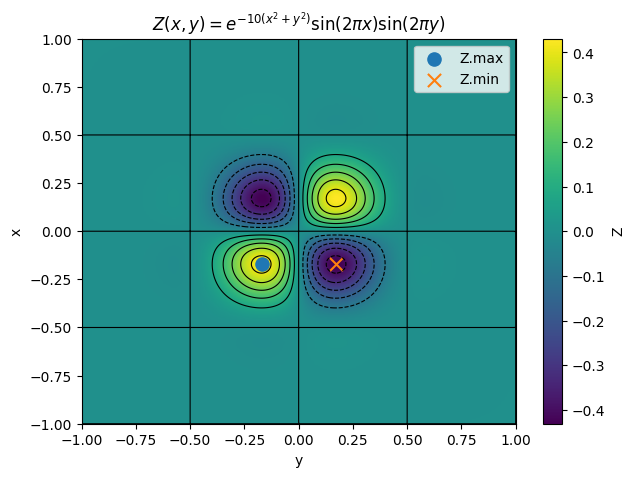

In [23]:
# -------------------------
# (d) Plot Z and mark max/min points
# -------------------------
# Convert indices -> actual coordinates
x_max, y_max = x[i_max].item(), y[j_max].item()
x_min, y_min = x[i_min].item(), y[j_min].item()

print("Max location (x, y) =", (x_max, y_max))
print("Min location (x, y) =", (x_min, y_min))

plt.figure(figsize=(7, 5))

im = plt.imshow(
    Z,
    origin="lower",
    extent=[y.min().item(), y.max().item(), x.min().item(), x.max().item()],
    aspect="auto",
)
plt.colorbar(im, label="Z")

# Contours (Matplotlib can often take CPU torch tensors directly)
plt.contour(Y, X, Z, levels=10, linewidths=0.8, colors="black")

# Mark max/min (note scatter uses (x-axis, y-axis) = (y, x) here due to extent choice)
plt.scatter(y_max, x_max, s=90, marker="o", label="Z.max")
plt.scatter(y_min, x_min, s=90, marker="x", label="Z.min")

plt.xlabel("y")
plt.ylabel("x")
plt.title(r"$Z(x,y)=e^{-10(x^2+y^2)}\sin(2\pi x)\sin(2\pi y)$")
plt.legend()
plt.show()

In [24]:
# IMPORTANT REMARK: Since Z(x, y) = Z(-x, -y), i.e., Z is an even function in both x and y, 
# there are two minima and two maxima located symmetrically about the origin. 
# You can mark both the minima and maxima, or just one of each as done here.

## Problem 7: _The Slow Way and the Right Way_ - Loops vs. Vectorization
Define the 2D function:
$F(x, y) = (x^2 y + y^3)/(1 + x^2 + y^2)$

Use a 2D grid on `x, y ∈ [-2, 2]` with `N = 600` points in each direction.

**(a)** Create `x`, `y`, and a meshgrid `X, Y` using:
- `torch.linspace`
- `torch.meshgrid(..., indexing="ij")`

In [25]:
import torch
import time

# Parameters
N = 600
x = torch.linspace(-2.0, 2.0, N)
y = torch.linspace(-2.0, 2.0, N)
X, Y = torch.meshgrid(x, y, indexing="ij")

**(b)** **Loop version:** Create a tensor `F_loop` of shape `(N, N)` and compute `F(x, y)` using **two nested loops** over grid indices.

In [26]:
# (b) Loop version
F_loop = torch.empty((N, N), dtype=torch.float32)
t0 = time.perf_counter()
for i in range(N):
    for j in range(N):
        F_loop[i, j] = (x[i]**2 * y[j] + y[j]**3) / (1 + x[i]**2 + y[j]**2)
t1 = time.perf_counter()
loop_time = t1 - t0


**(c)** **Vectorized version:** Compute the same function using **only tensor operations** on `X` and `Y` (no explicit loops).

In [27]:
# (c) Vectorized version
t0 = time.perf_counter()
F_vec = (X**2 * Y + Y**3) / (1 + X**2 + Y**2)
t1 = time.perf_counter()
vec_time = t1 - t0


**(d)** Verify correctness by computing:
- `max_error = max |F_loop − F_vec|`

In [28]:
# (d) Error check
max_error = (F_loop - F_vec).abs().max().item()

**(e)** Time both methods and report:
- loop runtime (seconds)
- vectorized runtime (seconds)
- speedup factor = (loop time) / (vectorized time)

In [29]:
print(f"Loop time: {loop_time} s")
print(f"Vectorized time: {vec_time} s")
print(f"Speedup: {loop_time/vec_time}")

Loop time: 3.839305541012436 s
Vectorized time: 0.0016652090125717223 s
Speedup: 2305.599784788021
